> This notebook updates our previous work [Previous notebook](Full_Pipeline_Fake_Receipt_Detection.ipynb), which successfully detected fake receipts. The update focuses on optimization, including removing unused models and improving image processing efficiency in Python.


# 0. Preparation


## 0.1 Import Some Libraries


In [1]:
import joblib
import cv2
import numpy as np
import re
from matplotlib import pyplot as plt
from dataclasses import dataclass, field
from typing import Tuple, List, Dict, Optional, Any
from cv2.typing import Rect

## 0.2 Define Some Python Data Type


In [2]:
Box = Tuple[int, int, int, int]


@dataclass
class LineExtractionResult:
    line_number: int
    text: str
    field: str
    boxes: List[Box]


@dataclass
class FieldVerification:
    expected: str
    actual: str
    is_match: bool


@dataclass
class VerificationSummary:
    passed: bool
    final_verdict: str


@dataclass
class LineCountValidationResult:
    is_valid: bool
    detected_lines: int
    expected_lines: int
    reason: str


@dataclass
class LayoutValidationResult:
    is_valid: bool
    similarity_score: float
    threshold: float
    detected_fingerprint: Any
    template_fingerprint: Any
    detailed_scores: Dict[str, float]
    violations: List[str]
    reason: str


@dataclass
class VerificationResult:
    summary: VerificationSummary = field(
        default_factory=lambda: VerificationSummary(
            passed=False,
            final_verdict="POTENTIALLY FAKE",
        )
    )
    field_verification: Optional[Dict[str, FieldVerification]] = None
    line_validation: Optional[LineCountValidationResult] = None
    layout_validation: Optional[LayoutValidationResult] = None
    early_detection: bool = True


@dataclass(frozen=True)
class LayoutFingerprint:
    num_lines: int = 0

    avg_line_height: float = 0.0
    std_line_height: float = 0.0

    avg_line_width: float = 0.0
    std_line_width: float = 0.0

    avg_line_gap: float = 0.0
    std_line_gap: float = 0.0

    alignment_variance: float = 0.0

    zone_distribution: List[float] = field(default_factory=lambda: [0.0, 0.0, 0.0])
    width_distribution: List[float] = field(default_factory=lambda: [0.0, 0.0, 0.0])

    line_y_positions: List[float] = field(default_factory=list)

# 1. Model Loading (OCR)


In [3]:
# only use logistic regression model for lightweight computation than others
logistic_model = joblib.load("../../output/models/logistic_regression_model.pkl")

# 2. Data Preprocessing


In [4]:
def preprocess_char(roi: np.ndarray) -> Optional[np.ndarray]:
    """
    Preprocess cropped ROI for model inference using
    EXACT SAME STEPS as training preprocess_digit().
    """

    # 1. ROI is already grayscale, no need for BGR2GRAY
    gray = roi.copy()

    # 2. threshold (binary inverse + Otsu)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3. find bounding box (same as training)
    ys, xs = np.where(bw == 255)
    if len(xs) == 0 or len(ys) == 0:
        return None

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    digit = bw[y1 : y2 + 1, x1 : x2 + 1]

    # 4. resize longest side to 22 px
    h, w = digit.shape
    if h > w:
        new_h, new_w = 22, int(w * (22 / h))
    else:
        new_w, new_h = 22, int(h * (22 / w))

    digit_resized = cv2.resize(digit, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 5. pad to 28x28
    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left

    digit_padded = cv2.copyMakeBorder(
        digit_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0
    )

    # 6. normalize + flatten
    digit_norm = digit_padded.astype("float32") / 255.0
    flat = digit_norm.flatten()

    return flat.reshape(1, -1)

# 3. Text Segmentation


In [5]:
def process_text_detection(
    image: np.ndarray,
) -> Tuple[
    np.ndarray, List[Tuple[int, int, int, int]], np.ndarray, np.ndarray, np.ndarray
]:
    """Your existing function - this works well"""
    print("\n1. Process text detection")
    
    
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        if w < 20 or h < 10:
            continue
        ratio = w / float(h)
        if ratio < 0.2 or ratio > 15:
            continue
        area = w * h
        if area < 50 or area > image.shape[0] * image.shape[1] * 0.5:
            continue

        boxes.append((x, y, w, h))
        cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return original, boxes, gray, edges, dilated


def process_line_grouping(
    boxes: List[Tuple[int, int, int, int]], line_threshold: int = 15
) -> List[List[Tuple[int, int, int, int]]]:
    """Group boxes that are on the same line"""
    print("\n2.1 Line Grouping")
    
    if not boxes:
        return []

    # Sort by Y position
    boxes_sorted = sorted(boxes, key=lambda box: box[1])

    lines = []
    current_line = []
    current_y = boxes_sorted[0][1]

    for box in boxes_sorted:
        x, y, w, h = box

        # Check if this box is on the same line (within threshold)
        if abs(y - current_y) <= line_threshold:
            current_line.append(box)
        else:
            # New line detected
            if current_line:
                # Sort boxes in the line by X coordinate (left to right)
                current_line_sorted = sorted(current_line, key=lambda b: b[0])
                lines.append(current_line_sorted)
            current_line = [box]
            current_y = y

    # Don't forget the last line
    if current_line:
        current_line_sorted = sorted(current_line, key=lambda b: b[0])
        lines.append(current_line_sorted)

    return lines


def merge_small_vertical_components(
    boxes: List[Rect],
    y_thresh: int = 10,
    x_overlap_ratio: float = 0.5,
    handle_colons: bool = True,
    colon_y_thresh: int = 35,
    colon_h_align_ratio: float = 0.6,
) -> List[Tuple[int, int, int, int]]:
    """
    Merge vertically separated components of the same character (like 'i', 'j', ':').

    Args:
        boxes: List of bounding boxes (x, y, w, h)
        y_thresh: Maximum vertical distance for general merging (i, j)
        x_overlap_ratio: Minimum horizontal overlap ratio required
        handle_colons: Whether to apply special logic for colons
        colon_y_thresh: Larger threshold for colon detection (vertical gap)
        colon_h_align_ratio: Horizontal alignment tolerance for colons

    Returns:
        List of merged bounding boxes
    """
    merged = []
    used = set()

    for i, (x1, y1, w1, h1) in enumerate(boxes):
        if i in used:
            continue

        merged_box = (x1, y1, w1, h1)
        merged_components = [i]

        # Keep searching for components to merge
        for j, (x2, y2, w2, h2) in enumerate(boxes):
            if i == j or j in used:
                continue

            # Update coordinates from current merged box
            mx, my, mw, mh = merged_box

            # Calculate vertical gap between boxes
            vertical_gap = min(abs((my + mh) - y2), abs((y2 + h2) - my))

            # Calculate horizontal overlap
            x_overlap = max(0, min(mx + mw, x2 + w2) - max(mx, x2))
            has_horizontal_overlap = x_overlap > min(mw, w2) * x_overlap_ratio

            # Check horizontal alignment (for colons)
            center_x1 = mx + mw / 2
            center_x2 = x2 + w2 / 2
            h_alignment = abs(center_x1 - center_x2) / max(mw, w2)
            is_horizontally_aligned = h_alignment < colon_h_align_ratio

            should_merge = False

            # Standard close merging (for 'i', 'j')
            if vertical_gap < y_thresh and has_horizontal_overlap:
                should_merge = True

            # Special colon handling
            if (
                handle_colons
                and vertical_gap < colon_y_thresh
                and is_horizontally_aligned
            ):
                # Check if components are small and similar in size
                area1 = mw * mh
                area2 = w2 * h2
                avg_area = (area1 + area2) / 2
                size_ratio = (
                    min(area1, area2) / max(area1, area2)
                    if max(area1, area2) > 0
                    else 0
                )

                # Both are small dots and similar size → likely colon
                if avg_area < 300 and size_ratio > 0.25:
                    should_merge = True

            if should_merge:
                # Merge into expanded bounding box
                nx = min(mx, x2)
                ny = min(my, y2)
                nw = max(mx + mw, x2 + w2) - nx
                nh = max(my + mh, y2 + h2) - ny

                merged_box = (nx, ny, nw, nh)
                merged_components.append(j)
                used.add(j)

        merged.append(merged_box)
        for comp_idx in merged_components:
            used.add(comp_idx)

    return merged


def segment_characters_grayscale(
    image_gray: np.ndarray,
    merge_vertical: bool = True,
    y_thresh: int = 10,
    x_overlap_ratio: float = 0.5,
) -> List[Rect]:
    """
    Segment characters from grayscale image with optional vertical merging.

    Args:
        image_gray: Grayscale input image
        merge_vertical: Whether to merge vertically separated components
        y_thresh: Vertical distance threshold for merging
        x_overlap_ratio: Horizontal overlap ratio for merging

    Returns:
        List of character bounding boxes sorted left to right
    """
    _, bw = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]

    # Merge vertical components for characters like 'i', 'j'
    if merge_vertical and len(boxes) > 0:
        boxes = merge_small_vertical_components(boxes, y_thresh, x_overlap_ratio)

    # Sort left to right
    boxes = sorted(boxes, key=lambda b: b[0])
    return boxes


def segment_characters(
    img_bgr: np.ndarray,
    merge_vertical: bool = True,
    y_thresh: int = 10,
    x_overlap_ratio: float = 0.5,
) -> List[Rect]:
    """
    Segment characters from BGR image with optional vertical merging.

    Args:
        img_bgr: BGR input image
        merge_vertical: Whether to merge vertically separated components
        y_thresh: Vertical distance threshold for merging
        x_overlap_ratio: Horizontal overlap ratio for merging

    Returns:
        List of character bounding boxes sorted left to right
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # find contours (characters)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # bounding boxes
    boxes = [cv2.boundingRect(c) for c in contours]

    # Merge vertical components for characters like 'i', 'j'
    if merge_vertical and len(boxes) > 0:
        boxes = merge_small_vertical_components(boxes, y_thresh, x_overlap_ratio)

    # sort left to right
    boxes = sorted(boxes, key=lambda b: b[0])

    return boxes

# 4. Text Extraction


Some text extraction helpers


In [6]:
def predict_char_models(roi: np.ndarray) -> str:
    """
    Run prediction using Logistic regression
    Return a string: (logistic_char)
    """
    processed = preprocess_char(roi)

    if processed is None:
        return ""

    # Logistic regression prediction
    log_pred = logistic_model.predict(processed)[0]

    return log_pred


def extract_text_from_line(
    image: np.ndarray, line_boxes: List[Tuple[int, int, int, int]]
) -> str:
    text_logistic = ""

    for x, y, w, h in line_boxes:
        # crop line region
        line_roi = image[y : y + h, x : x + w]

        # convert to grayscale if needed
        if len(line_roi.shape) == 3:
            gray_line = cv2.cvtColor(line_roi, cv2.COLOR_BGR2GRAY)
        else:
            gray_line = line_roi

        # segment characters inside this line - use grayscale version
        char_boxes = segment_characters_grayscale(gray_line)

        # visualize each character
        for i, (cx, cy, cw, ch) in enumerate(char_boxes):
            char_roi = gray_line[cy : cy + ch, cx : cx + cw]

            processed = preprocess_char(char_roi)
            if processed is None:
                print(f"   Character {i}: EMPTY or INVALID")
                continue

            # Predict (optional)
            pred_log = predict_char_models(char_roi)
            text_logistic += pred_log

    return text_logistic


def parse_line_by_position(line_text: str, line_number: int) -> Tuple[str, str]:
    t = line_text.lower()

    # Strong keyword-based classification
    if any(k in t for k in ["transfer berhasil", "berhasil"]):
        return "transaction_status", line_text

    if re.search(r"rp\s*\d", t):
        return "total_amount", line_text

    if any(
        m in t
        for m in [
            "wib",
            "jan",
            "feb",
            "mar",
            "apr",
            "mei",
            "jun",
            "jul",
            "agu",
            "sep",
            "okt",
            "nov",
            "des",
        ]
    ):
        return "datetime", line_text

    if "ref" in t and "id" in t:
        return "transaction_id", line_text

    if "penerima" in t:
        return "receiver_title", line_text

    # Name heuristics
    if any(prefix in t for prefix in ["sdri", "sdr", "bpk", "ibu"]):
        return "receiver_name", line_text

    if any(b in t for b in ["bni", "bca", "mandiri", "bri", "btn"]):
        return "receiver_bank", line_text

    if "sumber dana" in t:
        return "sender_title", line_text

    # Masked account
    if "***" in line_text or re.search(r"[xX]{4,}", t):
        return "sender_account", line_text

    # Detail transfer
    if "detail transfer" in t:
        return "detail_title", line_text

    # Nominal, Fee, Total lines
    if "nominal" in t:
        return "nominal_line", line_text
    if "biaya" in t:
        return "fee_line", line_text
    if t.startswith("total") or (" total " in t):
        return "total_line", line_text

    return "unknown", line_text


def extract_amount_from_text(text: str) -> Optional[int]:
    """Extract amount value from text"""
    amount_match = re.search(r"Rp\s*([\d.,]+)", text.replace(".", ""))
    if amount_match:
        amount_str = amount_match.group(1).replace(",", "")
        return int(amount_str) if amount_str.isdigit() else None
    return None


def parse_detail_line(text: str) -> Tuple[str, Optional[int]]:
    """Parse detail lines that have labels and amounts separated"""
    if "nominal" in text.lower():
        return "nominal", extract_amount_from_text(text)
    elif "biaya transaksi" in text.lower():
        return "fee", extract_amount_from_text(text)
    elif "total" in text.lower():
        return "total", extract_amount_from_text(text)
    return "unknown", None

In [7]:
def process_text_extraction(
    gray: np.ndarray, lines: List[List[Tuple[int, int, int, int]]]
) -> List[LineExtractionResult]:
    """Step 3: Extract text from each line using both models"""
    print("\n3. Extracting text from lines")
    lines_data = []

    for i, line_boxes in enumerate(lines):
        text = extract_text_from_line(gray, line_boxes)

        # Skip empty lines
        if not text.strip():
            continue

        # Parse using output
        field, parsed_log = parse_line_by_position(text, i)

        lines_data.append(
            LineExtractionResult(
                line_number=i,
                text=text,
                field=field,
                boxes=line_boxes,
            )
        )

    return lines_data

# 5. Verify Authenticity


In [8]:
def process_verification(
    line_items: List[LineExtractionResult],
    expected_fields: Dict[str, str],
) -> VerificationResult:
    """
    Verifies extracted receipt fields against expected values.
    """
    print("\n4. Verify authenticity")

    # ---------------------------------
    # Step 1: Collect detected fields
    # ---------------------------------
    detected_fields: Dict[str, str] = {}

    for item in line_items:
        if not item.field:
            continue

        # Keep first occurrence only
        if item.field not in detected_fields:
            detected_fields[item.field] = item.text

    # ---------------------------------
    # Step 2: Verify against expectations
    # ---------------------------------
    field_results: Dict[str, FieldVerification] = {}

    for f, expected_value in expected_fields.items():
        actual_value = detected_fields.get(f)

        if actual_value is None:
            continue

        field_results[f] = FieldVerification(
            expected=expected_value,
            actual=actual_value,
            is_match=expected_value.strip() == actual_value.strip(),
        )

    # ---------------------------------
    # Step 3: Final verdict
    # ---------------------------------
    passed = True
    for result in field_results.values():
        if not result.is_match:
            passed = False
            break

    summary = VerificationSummary(
        passed=passed,
        final_verdict="VALID RECEIPT" if passed else "POTENTIALLY FAKE",
    )

    return VerificationResult(
        field_verification=field_results,
        summary=summary,
    )

# 6. Layout Aware Receipt Verification


Visualization function helper


In [9]:
def get_field_colors() -> Dict[str, Tuple[int, int, int]]:
    """Get color mapping for different field types"""
    return {
        "app_logo": (255, 0, 0),  # Red
        "bank_name": (0, 0, 255),  # Blue
        "transaction_status": (0, 255, 0),  # Green
        "total_amount": (255, 255, 0),  # Cyan
        "datetime": (255, 0, 255),  # Magenta
        "transaction_id": (0, 255, 255),  # Yellow
        "receiver_title": (128, 0, 128),  # Purple
        "receiver_name": (128, 128, 0),  # Olive
        "receiver_bank": (0, 128, 128),  # Teal
        "sender_title": (128, 128, 128),  # Gray
        "sender_name": (64, 64, 64),  # Dark Gray
        "sender_account": (192, 192, 192),  # Light Gray
        "detail_title": (255, 165, 0),  # Orange
        "nominal_line": (255, 192, 203),  # Pink
        "fee_line": (173, 216, 230),  # Light Blue
        "total_line": (144, 238, 144),  # Light Green
        "unknown": (0, 0, 0),  # Black
    }


def extract_layout_fingerprint(
    lines: List[List[Tuple[int, int, int, int]]], image_shape: Tuple[int, int]
) -> LayoutFingerprint:
    """
    Extract structural features from receipt layout to create a fingerprint.

    Args:
        lines: List of line segments (each containing boxes)
        image_shape: (height, width) of the image

    Returns:
        Dictionary containing layout features
    """
    if not lines:
        return LayoutFingerprint()

    img_height, img_width = image_shape

    line_y_positions: List[float] = []
    line_heights: List[float] = []
    line_widths: List[float] = []
    line_x_starts: List[float] = []

    for line_boxes in lines:
        if not line_boxes:
            continue

        y_pos = line_boxes[0][1]
        line_y_positions.append(y_pos / img_height)

        y_min = min(box[1] for box in line_boxes)
        y_max = max(box[1] + box[3] for box in line_boxes)
        x_min = min(box[0] for box in line_boxes)
        x_max = max(box[0] + box[2] for box in line_boxes)

        line_heights.append((y_max - y_min) / img_height)
        line_widths.append((x_max - x_min) / img_width)
        line_x_starts.append(x_min / img_width)

    line_gaps: List[float] = [
        line_y_positions[i + 1] - line_y_positions[i]
        for i in range(len(line_y_positions) - 1)
    ]

    alignment_variance = float(np.var(line_x_starts)) if line_x_starts else 0.0

    total_lines = len(line_y_positions)

    zone_distribution = (
        [
            sum(1 for y in line_y_positions if y < 0.33) / total_lines,
            sum(1 for y in line_y_positions if 0.33 <= y < 0.67) / total_lines,
            sum(1 for y in line_y_positions if y >= 0.67) / total_lines,
        ]
        if total_lines
        else [0.0, 0.0, 0.0]
    )

    width_distribution = (
        [
            sum(1 for w in line_widths if w < 0.5) / total_lines,
            sum(1 for w in line_widths if 0.5 <= w < 0.8) / total_lines,
            sum(1 for w in line_widths if w >= 0.8) / total_lines,
        ]
        if total_lines
        else [0.0, 0.0, 0.0]
    )

    return LayoutFingerprint(
        num_lines=len(lines),
        avg_line_height=float(np.mean(line_heights)) if line_heights else 0.0,
        std_line_height=float(np.std(line_heights)) if line_heights else 0.0,
        avg_line_width=float(np.mean(line_widths)) if line_widths else 0.0,
        std_line_width=float(np.std(line_widths)) if line_widths else 0.0,
        avg_line_gap=float(np.mean(line_gaps)) if line_gaps else 0.0,
        std_line_gap=float(np.std(line_gaps)) if line_gaps else 0.0,
        alignment_variance=alignment_variance,
        zone_distribution=zone_distribution,
        width_distribution=width_distribution,
        line_y_positions=line_y_positions,
    )


def get_template_layout_fingerprint() -> Dict[str, Any]:
    """
    Define the expected layout fingerprint for valid receipts.
    These values should be calibrated based on your genuine receipt samples.

    Returns:
        Dictionary containing expected layout features with acceptable ranges
    """
    return {
        "num_lines": {"min": 10, "max": 20, "ideal": 15},
        "avg_line_height": {"min": 0.02, "max": 0.08, "ideal": 0.04},
        "avg_line_width": {"min": 0.5, "max": 0.95, "ideal": 0.75},
        "avg_line_gap": {"min": 0.02, "max": 0.10, "ideal": 0.05},
        "alignment_variance": {"max": 0.05},  # Lines should be mostly aligned
        # Zone distribution: [top%, middle%, bottom%]
        # Expected: more content in top and middle sections
        "zone_distribution": {
            "top": {"min": 0.2, "max": 0.5},
            "middle": {"min": 0.3, "max": 0.6},
            "bottom": {"min": 0.1, "max": 0.4},
        },
        # Width distribution: [narrow%, medium%, wide%]
        "width_distribution": {
            "narrow": {"max": 0.3},  # Few narrow lines
            "medium": {"min": 0.2, "max": 0.6},
            "wide": {"min": 0.3, "max": 0.8},  # Many wide lines
        },
    }


def calculate_layout_similarity(
    detected: LayoutFingerprint, template: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Calculate similarity score between detected layout and template.

    Args:
        detected: Extracted layout fingerprint from image
        template: Expected layout fingerprint

    Returns:
        Dictionary containing similarity scores and detailed analysis
    """
    scores = {}
    violations = []

    # 1. Number of lines check
    num_lines = detected.num_lines
    if template["num_lines"]["min"] <= num_lines <= template["num_lines"]["max"]:
        scores["num_lines"] = 1.0
    else:
        scores["num_lines"] = 0.0
        violations.append(
            f"Line count {num_lines} outside range [{template['num_lines']['min']}, {template['num_lines']['max']}]"
        )

    # 2. Average line height check
    avg_height = detected.avg_line_height
    if (
        template["avg_line_height"]["min"]
        <= avg_height
        <= template["avg_line_height"]["max"]
    ):
        scores["avg_line_height"] = 1.0
    else:
        scores["avg_line_height"] = 0.0
        violations.append(
            f"Average line height {avg_height:.3f} outside expected range"
        )

    # 3. Average line width check
    avg_width = detected.avg_line_width
    if (
        template["avg_line_width"]["min"]
        <= avg_width
        <= template["avg_line_width"]["max"]
    ):
        scores["avg_line_width"] = 1.0
    else:
        scores["avg_line_width"] = 0.0
        violations.append(f"Average line width {avg_width:.3f} outside expected range")

    # 4. Line spacing consistency
    avg_gap = detected.avg_line_gap
    if template["avg_line_gap"]["min"] <= avg_gap <= template["avg_line_gap"]["max"]:
        scores["avg_line_gap"] = 1.0
    else:
        scores["avg_line_gap"] = 0.0
        violations.append(f"Line spacing {avg_gap:.3f} inconsistent with template")

    # 5. Alignment check
    alignment_var = detected.alignment_variance
    if alignment_var <= template["alignment_variance"]["max"]:
        scores["alignment"] = 1.0
    else:
        scores["alignment"] = 0.0
        violations.append(f"Poor alignment detected (variance: {alignment_var:.3f})")

    # 6. Zone distribution check
    zone_dist = detected.zone_distribution
    zone_score = 0
    zone_checks = 0

    zones = ["top", "middle", "bottom"]
    for i, zone in enumerate(zones):
        zone_checks += 1
        zone_val = zone_dist[i]
        zone_template = template["zone_distribution"][zone]

        if zone_template["min"] <= zone_val <= zone_template["max"]:
            zone_score += 1
        else:
            violations.append(
                f"{zone.capitalize()} zone density {zone_val:.2f} outside [{zone_template['min']}, {zone_template['max']}]"
            )

    scores["zone_distribution"] = zone_score / zone_checks if zone_checks > 0 else 0

    # 7. Width distribution check
    width_dist = detected.width_distribution
    width_score = 0
    width_checks = 0

    width_types = ["narrow", "medium", "wide"]
    for i, width_type in enumerate(width_types):
        width_checks += 1
        width_val = width_dist[i]
        width_template = template["width_distribution"][width_type]

        if "min" in width_template and "max" in width_template:
            if width_template["min"] <= width_val <= width_template["max"]:
                width_score += 1
            else:
                violations.append(
                    f"{width_type.capitalize()} lines ratio {width_val:.2f} outside expected range"
                )
        elif "max" in width_template:
            if width_val <= width_template["max"]:
                width_score += 1
            else:
                violations.append(f"Too many {width_type} lines: {width_val:.2f}")

    scores["width_distribution"] = width_score / width_checks if width_checks > 0 else 0

    # Calculate overall similarity score (weighted average)
    weights = {
        "num_lines": 0.20,
        "avg_line_height": 0.10,
        "avg_line_width": 0.10,
        "avg_line_gap": 0.10,
        "alignment": 0.15,
        "zone_distribution": 0.20,
        "width_distribution": 0.15,
    }

    overall_score = sum(scores[key] * weights[key] for key in scores.keys())

    return {
        "overall_score": overall_score,
        "detailed_scores": scores,
        "violations": violations,
        "is_similar": overall_score >= 0.65,  # Threshold: 65% similarity required
    }


def validate_layout_structure(
    lines: List[List[Tuple[int, int, int, int]]],
    image_shape: Tuple[int, int],
    similarity_threshold: float = 0.65,
) -> LayoutValidationResult:
    """
    Validate if the detected layout structure matches the expected receipt template.
    """
    print("2.3 Validate layout structure")

    detected_fingerprint = extract_layout_fingerprint(lines, image_shape)
    template_fingerprint = get_template_layout_fingerprint()

    similarity_result = calculate_layout_similarity(
        detected_fingerprint, template_fingerprint
    )

    is_valid = similarity_result["is_similar"]
    overall_score = similarity_result["overall_score"]

    reason = ""

    if not is_valid:
        reason = (
            f"Layout structure mismatch (similarity: {overall_score:.1%}). "
            "This receipt has a different layout than expected. "
            "Likely FAKE or wrong receipt type."
        )

        if similarity_result["violations"]:
            reason += (
                f"\nKey violations: {'; '.join(similarity_result['violations'][:3])}"
            )
    else:
        reason = (
            f"Layout structure matches expected template "
            f"(similarity: {overall_score:.1%})."
        )

    return LayoutValidationResult(
        is_valid=is_valid,
        similarity_score=overall_score,
        threshold=similarity_threshold,
        detected_fingerprint=detected_fingerprint,
        template_fingerprint=template_fingerprint,
        detailed_scores=similarity_result["detailed_scores"],
        violations=similarity_result["violations"],
        reason=reason,
    )


def validate_line_count(
    lines: List[List[Tuple[int, int, int, int]]],
    correct_lines: int,
) -> LineCountValidationResult:
    """
    Validate if the number of detected line segments is within acceptable range.
    Receipts with too many or too few lines are likely fake/edited.

    Args:
        lines: List of line segments (each containing boxes)
        min_lines: Minimum expected line count for a valid receipt
        max_lines: Maximum expected line count for a valid receipt

    Returns:
        Dictionary containing validation result and details
    """
    print("2.2 Validate line count")
    
    num_lines = len(lines)
    is_valid = correct_lines == num_lines

    if num_lines != correct_lines:
        reason = f"Detected ({num_lines}). Total detected lines not match with the correct one. Likely FAKE or edited image."
    else:
        reason = f"Line count ({num_lines}) is within acceptable range."

    return LineCountValidationResult(
        is_valid=is_valid,
        detected_lines=num_lines,
        expected_lines=correct_lines,
        reason=reason,
    )


def display_verification_results(verification: VerificationResult) -> None:
    """Step 5: Display verification results in console"""
    print("\n5. VERIFICATION RESULT")

    # Display layout structure validation if present
    if verification.layout_validation is not None:
        layout_val = verification.layout_validation
        print("\n--- Layout Structure Validation ---")
        print(f"Similarity Score: {layout_val.similarity_score:.1%}")
        print(f"Threshold       : {layout_val.threshold:.1%}")
        print(f"Status          : {'PASS' if layout_val.is_valid else 'FAIL'}")
        print(f"Reason          : {layout_val.reason}")

        # Show detailed scores
        if layout_val.detailed_scores:
            print("\nDetailed Scores:")
            for metric, score in layout_val.detailed_scores.items():
                status = "✓" if score >= 0.5 else "✗"
                print(f"  {status} {metric}: {score:.1%}")

        if not layout_val.is_valid:
            print("\n EARLY DETECTION: Receipt is FAKE based on layout structure!")
            return

    print(f"FINAL VERDICT   : {verification.summary.final_verdict}")


def create_legend_image(lines_data: List[LineExtractionResult]) -> np.ndarray:
    """Create legend image showing detected field types"""
    colors = get_field_colors()
    legend_img = np.ones((400, 400, 3), dtype=np.uint8) * 255
    y_offset = 30

    for field_type, color in colors.items():
        if any(field_type == line.field for line in lines_data):
            cv2.putText(
                legend_img,
                field_type,
                (10, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                color,
                1,
            )
            y_offset += 20

    return legend_img


def visualize_results(
    image: np.ndarray,
    result_img: np.ndarray,
    annotated_img: np.ndarray,
    lines_data: List[LineExtractionResult],
) -> None:
    """Step 6: Create and display visualization"""
    print("\n6. Create visualization")
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Text Detection")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Layout Analysis")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    legend_img = create_legend_image(lines_data)
    plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Field Types")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Anotation helper


In [10]:
def create_annotated_image(
    image: np.ndarray,
    lines_data: List[LineExtractionResult],
    verification: VerificationResult,
) -> np.ndarray:
    """Create annotated image with bounding boxes and labels"""
    annotated_img = image.copy()
    colors = get_field_colors()

    # Draw annotated boxes
    for line_data in lines_data:
        color = colors.get(line_data.field, (0, 0, 0))

        for box in line_data.boxes:
            x, y, w, h = box
            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), color, 2)

        # Add field type label using first box in line
        if line_data.boxes:
            x, y, w, h = line_data.boxes[0]
            label = line_data.field
            cv2.putText(
                annotated_img,
                label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2,
            )

    # Add final result to image
    final_result = verification.summary.final_verdict

    result_text = f"Result: {final_result}"

    cv2.putText(
        annotated_img, result_text, (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3
    )

    return annotated_img

Layout aware receipt verification


In [11]:
def layout_aware_receipt_verification(
    image_path: str, expected_amount: Dict[str, Any]
) -> Tuple[VerificationResult, List[LineExtractionResult]]:
    """Complete pipeline with layout awareness"""
    print("=== LAYOUT-AWARE RECEIPT VERIFICATION ===")

    # Load and validate image
    image = cv2.imread(image_path)
    if image is None:
        return VerificationResult(), []

    # Step 1: Detect text regions
    result_img, boxes, gray, edges, dilated = process_text_detection(image)

    # Step 2.1: Group boxes by lines
    lines = process_line_grouping(boxes, line_threshold=15)

    # Step 2.2: EARLY VALIDATION - Check line count
    line_validation = validate_line_count(lines, correct_lines=15)

    if not line_validation.is_valid:
        # Create early fake detection result
        verification = VerificationResult(
            summary=VerificationSummary(
                passed=False,
                final_verdict="POTENTIALLY FAKE",
            ),
            line_validation=line_validation,
        )

        # Display results
        display_verification_results(verification)

        # Create simple annotated image showing fake detection
        annotated_img = image.copy()
        cv2.putText(
            annotated_img,
            "FAKE RECEIPT DETECTED!",
            (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),  # Red color
            3,
        )
        cv2.putText(
            annotated_img,
            line_validation.reason,
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),
            2,
        )

        visualize_results(image, result_img, annotated_img, [])

        return verification, []

    # Step 2.3: ADVANCED VALIDATION - Check layout structure
    layout_validation = validate_layout_structure(
        lines, image_shape=(image.shape[0], image.shape[1]), similarity_threshold=0.65
    )

    if not layout_validation.is_valid:
        # Create early fake detection result
        verification = VerificationResult(
            summary=VerificationSummary(passed=False, final_verdict="POTENTIALLY FAKE"),
            line_validation=line_validation,
            layout_validation=layout_validation,
        )

        # Display results
        display_verification_results(verification)

        # Create annotated image showing layout mismatch
        annotated_img = image.copy()
        cv2.putText(
            annotated_img,
            "FAKE RECEIPT DETECTED!",
            (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            3,
        )
        cv2.putText(
            annotated_img,
            f"Layout Similarity: {layout_validation.similarity_score:.1%}",
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),
            2,
        )
        cv2.putText(
            annotated_img,
            "Different layout structure detected!",
            (20, 100),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            2,
        )

        visualize_results(image, result_img, annotated_img, [])

        return verification, []

    # Step 3: Extract text from each line
    lines_data = process_text_extraction(gray, lines)

    # Step 4: Verify authenticity
    verification = process_verification(lines_data, expected_amount)

    # Add line validation to verification results
    verification.line_validation = line_validation
    verification.layout_validation = layout_validation
    verification.early_detection = False

    # Step 5: Display results
    display_verification_results(verification)

    # Step 6: Create visualization
    annotated_img = create_annotated_image(image, lines_data, verification)
    visualize_results(image, result_img, annotated_img, lines_data)

    return verification, lines_data

# 7. Testing


In [12]:
def main(image_path: str, expected_amount: str) -> None:
    """Test with your actual receipt image"""

    expected_fields = {"total_amount": expected_amount.lower()}

    result, lines_data = layout_aware_receipt_verification(image_path, expected_fields)

    # Check if early detection triggered
    if result.early_detection:
        print("\n" + "=" * 60)
        print("⚠️  FAKE RECEIPT DETECTED IN EARLY VALIDATION")
        print("=" * 60)
        print("Processing stopped. No need for further OCR analysis.")
        return

    print("\n" + "=" * 60)
    print("DETAILED LAYOUT ANALYSIS:")
    print("=" * 60)
    print(f"Total lines: {len(lines_data)}")
    for line in lines_data:
        print(f"Line {line.line_number:2d}:")
        print(f"   -> {line.field:15} | '{line.text}'")

    # Visualization
    print("\n" + "=" * 60)
    print("VISUALIZING EACH SEGMENT:")
    print("=" * 60)

    image = cv2.imread(image_path)
    if image is None:
        raise Exception("Image is not found!")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Layout: 2 columns → image + Logistic result
    num_lines = len(lines_data)
    cols = 2
    rows = num_lines

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))

    # Handle single-row case
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, line in enumerate(lines_data):
        boxes = line.boxes
        if not boxes:
            continue

        # Combined bounding box
        x_min = min(box[0] for box in boxes)
        y_min = min(box[1] for box in boxes)
        x_max = max(box[0] + box[2] for box in boxes)
        y_max = max(box[1] + box[3] for box in boxes)

        line_roi = gray[y_min:y_max, x_min:x_max]

        # Segment image
        axes[i, 0].imshow(line_roi, cmap="gray")
        axes[i, 0].set_title(f"Line {line.line_number}", fontsize=10)
        axes[i, 0].axis("off")

        # Logistic prediction
        axes[i, 1].text(
            0.5,
            0.5,
            f"Logistic:\n{line.field}\n\n'{line.text}'",
            ha="center",
            va="center",
            fontsize=9,
            wrap=True,
        )
        axes[i, 1].set_title("Logistic Prediction", fontsize=10)
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.suptitle("Segment-by-Segment Analysis (Logistic Only)", fontsize=14, y=1.002)
    plt.show()

=== LAYOUT-AWARE RECEIPT VERIFICATION ===

1. Process text detection

2.1 Line Grouping
2.2 Validate line count

5. VERIFICATION RESULT
FINAL VERDICT   : POTENTIALLY FAKE

6. Create visualization


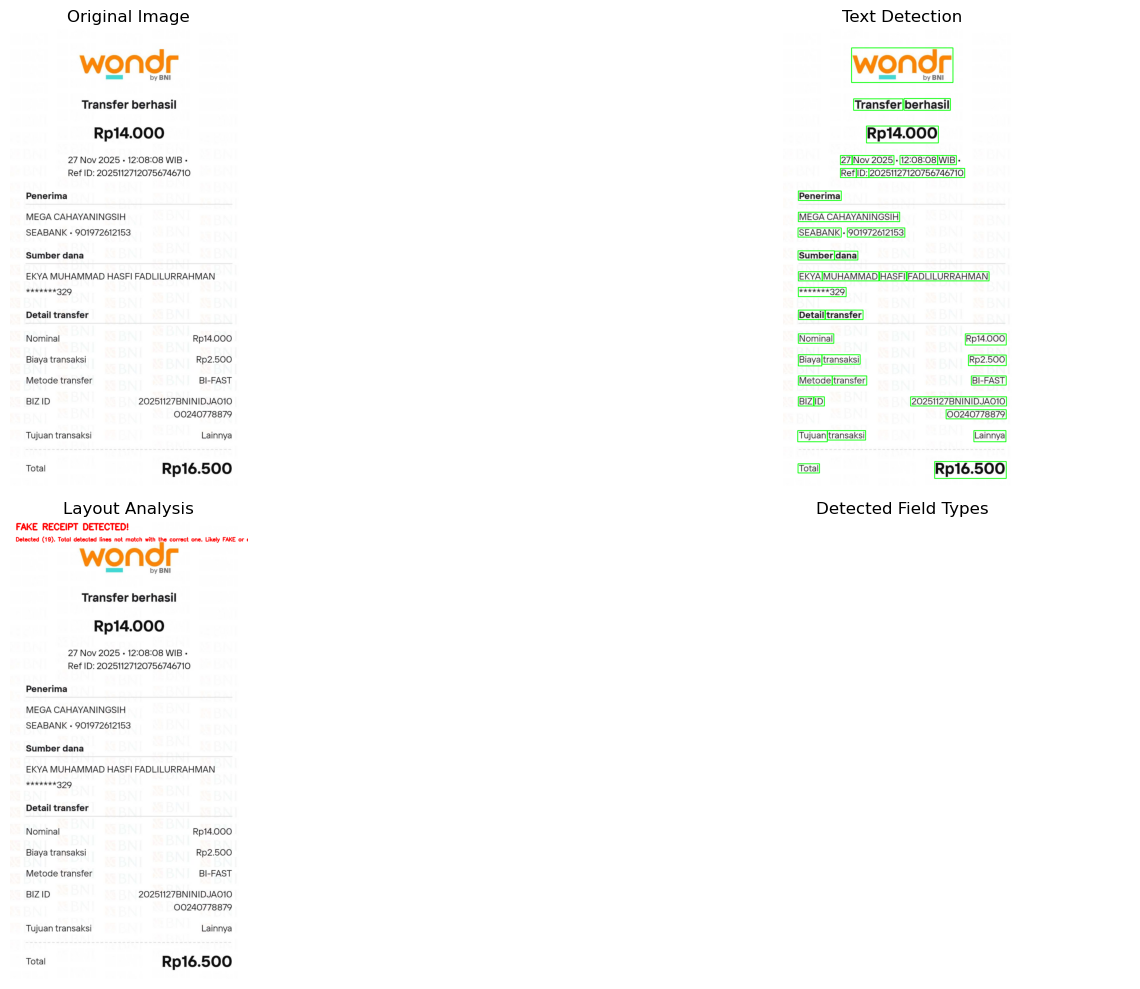


⚠️  FAKE RECEIPT DETECTED IN EARLY VALIDATION
Processing stopped. No need for further OCR analysis.


In [13]:
main(image_path="../../input/new/unusual_01.jpg", expected_amount="Rp14.000")

=== LAYOUT-AWARE RECEIPT VERIFICATION ===

1. Process text detection

2.1 Line Grouping
2.2 Validate line count
2.3 Validate layout structure

3. Extracting text from lines

4. Verify authenticity

5. VERIFICATION RESULT

--- Layout Structure Validation ---
Similarity Score: 75.0%
Threshold       : 65.0%
Status          : PASS
Reason          : Layout structure matches expected template (similarity: 75.0%).

Detailed Scores:
  ✓ num_lines: 100.0%
  ✓ avg_line_height: 100.0%
  ✗ avg_line_width: 0.0%
  ✓ avg_line_gap: 100.0%
  ✓ alignment: 100.0%
  ✓ zone_distribution: 100.0%
  ✗ width_distribution: 0.0%
FINAL VERDICT   : VALID RECEIPT

6. Create visualization


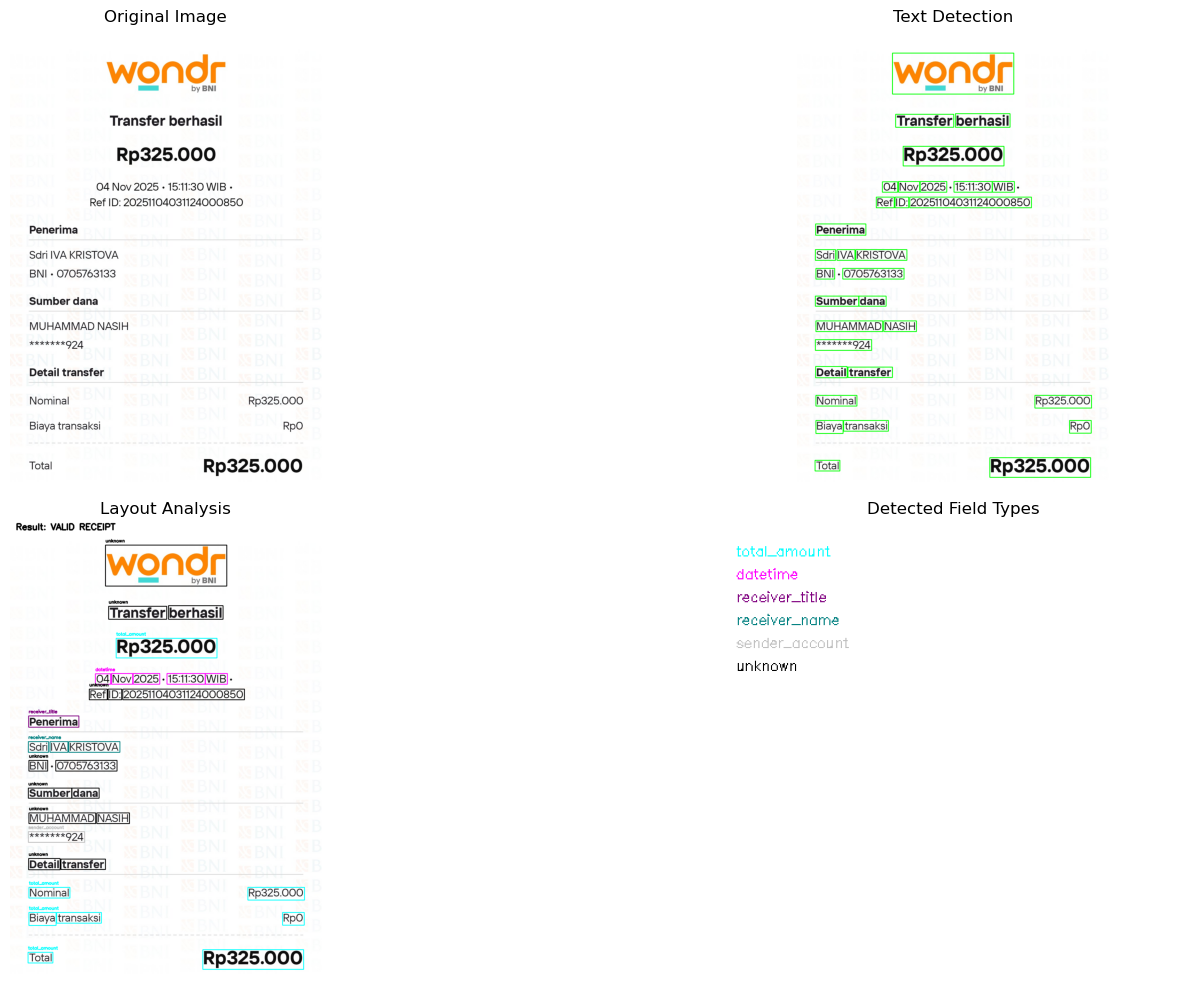


DETAILED LAYOUT ANALYSIS:
Total lines: 15
Line  0:
   -> unknown         | 'w2n4bynr'
Line  1:
   -> unknown         | 'transferberbasil'
Line  2:
   -> total_amount    | 'rp325.000'
Line  3:
   -> datetime        | '04nov202515:11:30w:b'
Line  4:
   -> unknown         | 'ref:d:20251104031124000850'
Line  5:
   -> receiver_title  | 'penerima'
Line  6:
   -> receiver_name   | 'sdrl:varr:stova'
Line  7:
   -> unknown         | 'bn:0705763133'
Line  8:
   -> unknown         | 'sumberdana'
Line  9:
   -> unknown         | 'mdnammadna8:n'
Line 10:
   -> sender_account  | '*******924'
Line 11:
   -> unknown         | 'detai:transfer'
Line 12:
   -> total_amount    | 'nomlna:rp325.000'
Line 13:
   -> total_amount    | 'blayatransakslrp0'
Line 14:
   -> total_amount    | 'tota:rp325.000'

VISUALIZING EACH SEGMENT:


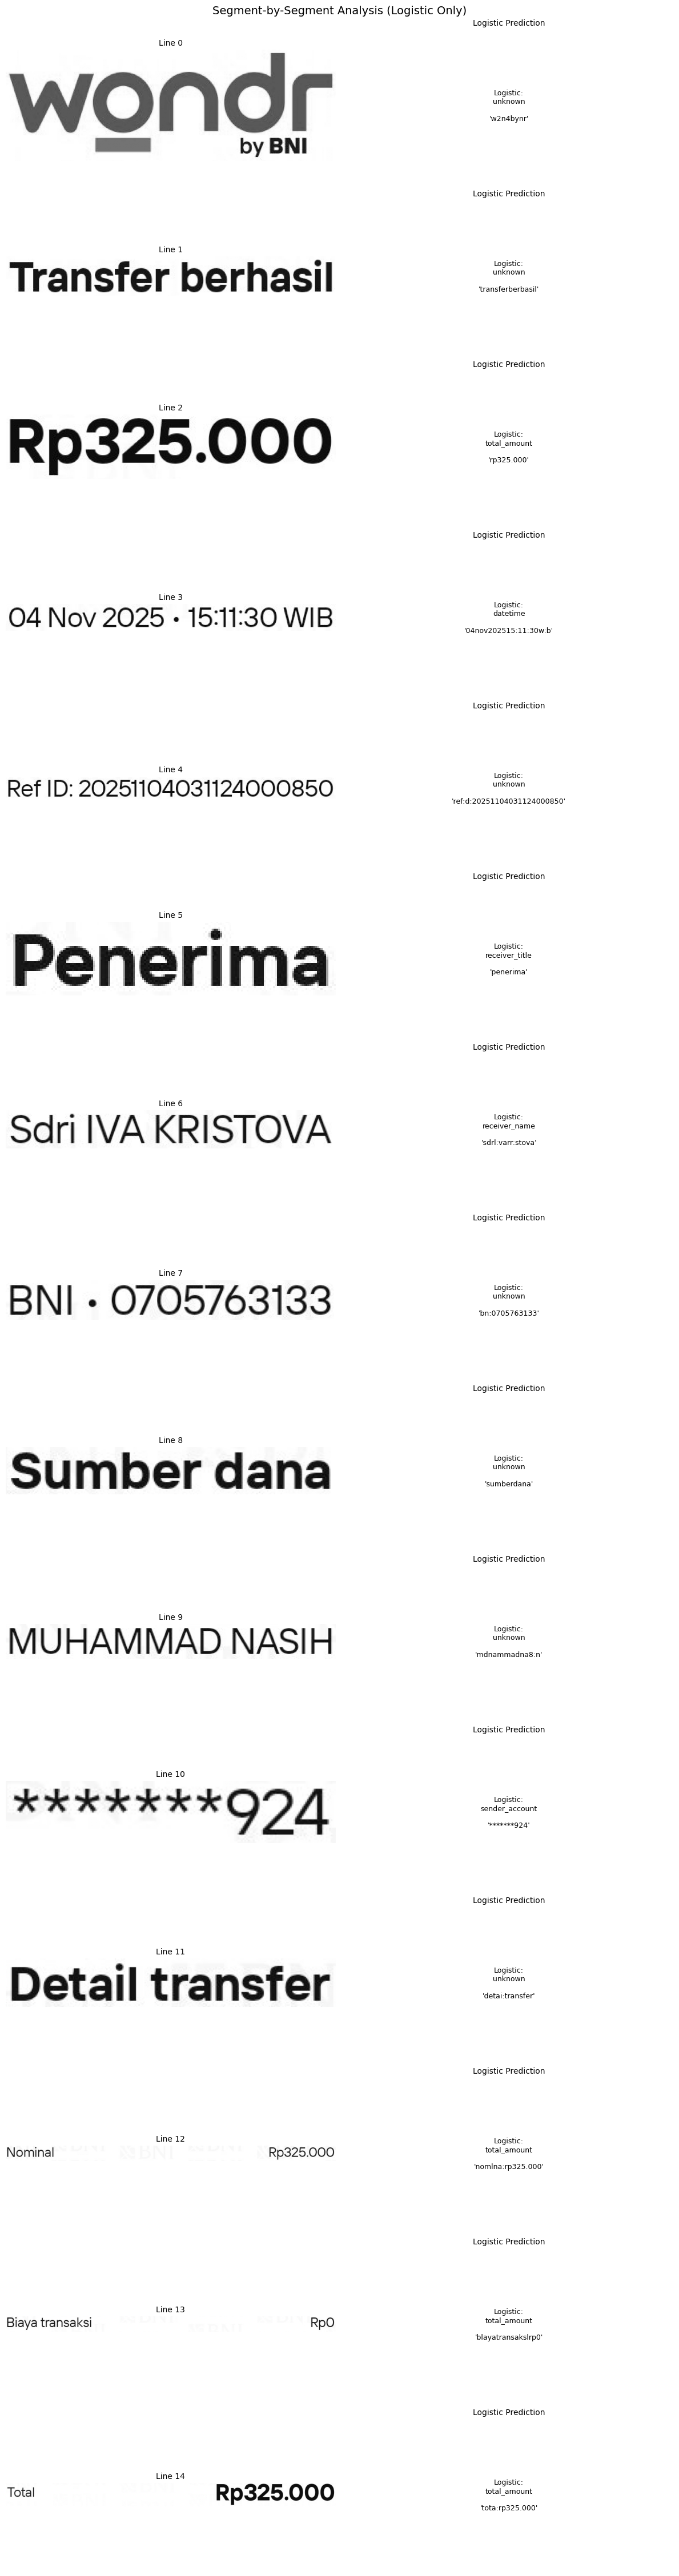

In [14]:
main(image_path="../../input/new/template_01.jpg", expected_amount="Rp325.000")